# PIP model 🐾 🤖
In this notebook I import and play with my PIP model, designed in blender

In [1]:
!pip install pybullet

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 103.2/103.2 MB 5.6 MB/s eta 0:00:00


## GPU e CPU setting  🌇 🎥
In Colab u cannot directly connect with `p.connect(GUI)`, that would be necessary for rendering, that's why u gotta adapt thing up a little.

In the cell below we set things up for rendering as explained in this notebook [Here](https://colab.research.google.com/drive/1u6j7JOqM05vUUjpVp5VNk0pd8q-vqGlx#scrollTo=fJXFN4U7NIRC)

In [2]:
#you can enable the GPU by changing the runtime
import os
os.environ['MESA_GL_VERSION_OVERRIDE'] = '3.3'
os.environ['MESA_GLSL_VERSION_OVERRIDE'] = '330'
import pybullet as p
import pybullet_data as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
from matplotlib import pylab
from google.colab import widgets
import random
import time

p.connect(p.DIRECT)
#allow to find the assets (URDF, obj, textures etc)
p.setAdditionalSearchPath(pd.getDataPath())

#optionally enable GPU for faster rendering in pybullet.getCameraImage
enableGPU = False
!ln -sf /opt/bin/nvidia-smi /usr/bin/nvidia-smi
!pip install gputil
import GPUtil as GPU
import sys
# Get all device ids and their processing and memory utiliazion
# (deviceIds, gpuUtil, memUtil) = GPU.getGPUs()

# Print os and python version information
print('OS: ' + sys.platform)
print(sys.version)

# Print package name and version number
print(GPU.__name__ + ' ' + GPU.__version__)

# Show the utilization of all GPUs in a nice table
GPU.showUtilization()

# Show all stats of all GPUs in a nice table
GPU.showUtilization(all=True)

# NOTE: If all your GPUs currently have a memory consumption larger than 1%,
# this step will fail. It's not a bug! It is intended to do so, if it does not
# find an available GPU.
GPUs = GPU.getGPUs()
numGPUs = len(GPU.getGPUs())
print("numGPUs=",numGPUs)
if numGPUs > 0:
  enableGPU = True
eglPluginId = -1
if enableGPU:
  import pkgutil
  egl = pkgutil.get_loader('eglRenderer')
  if (egl):
    eglPluginId = p.loadPlugin(egl.get_filename(), "_eglRendererPlugin")
  else:
    eglPluginId = p.loadPlugin("eglRendererPlugin")

if eglPluginId>=0:
  print("Using GPU hardware (eglRenderer)")
else:
  print("using CPU renderer (TinyRenderer)")

  Preparing metadata (setup.py) ... done
  Created wheel for gputil: filename=GPUtil-1.4.0-py3-none-any.whl size=7392 sha256=d3e1db4e078affd99abe1e45f4fe3bf2954dd3118045cbeb4acb2c23614167a2
  Stored in directory: /root/.cache/pip/wheels/a9/8a/bd/81082387151853ab8b6b3ef33426e98f5cbfebc3c397a9d4d0
Successfully built gputil
OS: linux
3.10.12 (main, Sep 11 2024, 15:47:36) [GCC 11.4.0]
GPUtil 1.4.0
| ID | GPU | MEM |
------------------
| ID | Name | Serial | UUID || GPU temp. | GPU util. | Memory util. || Memory total | Memory used | Memory free || Display mode | Display active |
--------------------------------------------------------------------------------------------------------------------------------------------------
numGPUs= 0
using CPU renderer (TinyRenderer)


In [3]:
!git clone https://github.com/Gaianeve/Real_Mega_Fufi.git

Cloning into 'Real_Mega_Fufi'...
remote: Enumerating objects: 153, done.
remote: Counting objects: 100% (153/153), done.
remote: Compressing objects: 100% (142/142), done.
remote: Total 153 (delta 66), reused 0 (delta 0), pack-reused 0 (from 0)
Receiving objects: 100% (153/153), 948.95 KiB | 2.56 MiB/s, done.
Resolving deltas: 100% (66/66), done.


## Loading model 📡 🛰

In [4]:
%cd Real_Mega_Fufi/Robot/PIPPA

/content/Real_Mega_Fufi/Robot/PIPPA


In [6]:
p.resetSimulation()
p.configureDebugVisualizer(p.COV_ENABLE_GUI)
#tell him to slide freely on the ground plane
useFixedBase = False
flags = p.URDF_INITIALIZE_SAT_FEATURES

plane_pos = [0,0,-0.1]
plane = p.loadURDF("plane.urdf", plane_pos, flags = flags, useFixedBase=useFixedBase)
PIP_position = [0,0,0]
orientation  = [0,0,0]
PIP_orientation = p.getQuaternionFromEuler(orientation)
PIPPA_id = p.loadURDF("PIPPA.urdf",basePosition = PIP_position,baseOrientation = PIP_orientation,\
                      useFixedBase=useFixedBase)
#mettiamo na sferetta nell'origine così possiamo capire dove si trova
sphere = p.loadURDF("sphere_small.urdf", basePosition=[0, 0, 0], globalScaling=3)


## Useful info and tools 🎮 📚 🏮
Print name and index of the joints and links. Link indexes are estabilished based on the links hierarchy, that's why `'Bottom_straight_link'` act as the base, and therefor has index `-1`. The other links are all indexed according to the order the are defined with in the urdf file.

              Practical table not to be wrong
---
---

Nome del Link	  🔗 📛   -------->       Indice 🔢 🥦

---
---


* Top_core -----> -1
* Bottom_Link_1	-----> 0
* Bottom_Link_2	-----> 1
* Bottom_Link_3	-----> 2
* Colonna_Link_1	-----> 3
* Colonna_Link_2	-----> 4
* Colonna_Link_3	-----> 5
* Cover_Link1	-----> 6
* Cover_Link_2	-----> 7
* Cover_Link_3	-----> 8
* Elastic_Joint_Link_1 ----->	9
* Elastic_Joint_link_2 ----->	10
* Elastic_Joint_link_3 ----->	11
* Gamba_Link_1	-----> 12
* Gamba_Link_2	-----> 13
* Gamba_Link_3	-----> 14
* Top_Link_1	-----> 15
* Top_Link_2	-----> 16
* Top_Link_3	-----> 17


In [7]:
# Get the number of joints
num_joints = p.getNumJoints(PIPPA_id)
print(f"Number of joints: {num_joints}")

# Get information about each joint
for joint_index in range(num_joints):
    joint_info = p.getJointInfo(PIPPA_id, joint_index)
    joint_name = joint_info[1].decode('UTF-8')  # Decode bytes to string
    joint_type = joint_info[2]  # Joint type (e.g., revolute, spherical)

    print(f"Joint Index: {joint_index}, Name: {joint_name}, Type: {joint_type}")

Number of joints: 18
Joint Index: 0, Name: Cover_to_top_1, Type: 4
Joint Index: 1, Name: Cover_to_leg_1, Type: 4
Joint Index: 2, Name: Leg_to_elastic_1, Type: 4
Joint Index: 3, Name: elastic_to_column_1, Type: 4
Joint Index: 4, Name: Bottom_to_Column_1, Type: 4
Joint Index: 5, Name: Bottom_straight_to_1, Type: 4
Joint Index: 6, Name: Cover_to_top_2, Type: 4
Joint Index: 7, Name: Cover_to_leg_2, Type: 4
Joint Index: 8, Name: Leg_to_elastic_2, Type: 4
Joint Index: 9, Name: elastic_to_column_2, Type: 4
Joint Index: 10, Name: Bottom_to_column_2, Type: 4
Joint Index: 11, Name: Bottom_stright_to_2, Type: 4
Joint Index: 12, Name: Cover_to_top_3, Type: 4
Joint Index: 13, Name: Cover_to_leg_3, Type: 4
Joint Index: 14, Name: Leg_to_elastic_3, Type: 4
Joint Index: 15, Name: elastic_to_column_3, Type: 4
Joint Index: 16, Name: Bottom_to_column3, Type: 4
Joint Index: 17, Name: Bottom_straight_to__3, Type: 4


In [8]:
# Indexes of the links in the urdf file. This function basically gives the definition order.
import xml.etree.ElementTree as ET

# Load the URDF file
urdf_file_path = 'PIPPA.urdf'

# Parse the URDF file
tree = ET.parse(urdf_file_path)
root = tree.getroot()

# Find all links in the URDF file and print their names with indices
links = []
for i, link in enumerate(root.findall('link')):
    link_name = link.attrib.get('name', f'Unnamed_{i}')
    links.append((i, link_name))

# Print link indices and names
for index, name in links:
    print(f"Link index: {index}, Link name: {name}")


Link index: 0, Link name: Bottom_Link_1
Link index: 1, Link name: Bottom_Link_2
Link index: 2, Link name: Bottom_Link_3
Link index: 3, Link name: Colonna_Link_1
Link index: 4, Link name: Colonna_Link_2
Link index: 5, Link name: Colonna_Link_3
Link index: 6, Link name: Cover_Link1
Link index: 7, Link name: Cover_Link_2
Link index: 8, Link name: Cover_Link_3
Link index: 9, Link name: Elastic_Joint_Link_1
Link index: 10, Link name: Elastic_Joint_link_2
Link index: 11, Link name: Elastic_Joint_link_3
Link index: 12, Link name: Gamba_Link_1
Link index: 13, Link name: Gamba_Link_2
Link index: 14, Link name: Gamba_Link_3
Link index: 15, Link name: Top_Link_1
Link index: 16, Link name: Top_Link_2
Link index: 17, Link name: Top_Link_3
Link index: 18, Link name: Top_core


## Changing material of the links ⛵ 🦚
Assign material trough the properties by changing dinamics. Everything about elastic joint Young modulus is being dealt with in the urdf file.

Basically, the joint is modelized as a *neo hookean* soft body  ♨ 🗻. Again, see the guide or my notes for the details.

In [9]:
# AL 6082 (Alluminio)
lateralFriction_Al = 0.3
restitution_Al = 0.2
rollingFriction_Al = 0.001
spinningFriction_Al = 0.01
linearDamping_Al = 0.04
angularDamping_Al = 0.1
contactStiffness_Al = 3e6
contactDamping_Al = 800

# AISI 304 (Acciaio Inox)
lateralFriction_AISI = 0.4
restitution_AISI = 0.1
rollingFriction_AISI = 0.001
spinningFriction_AISI= 0.05
linearDamping_AISI = 0.03
angularDamping_AISI = 0.1
contactStiffness_AISI = 8e6
contactDamping_AISI = 1500

# Acciaio Maraging (Maragià per gli amici)
lateralFriction_Mar = 0.3
restitution_Mar = 0.2
rollingFriction_Mar = 0.001
spinningFriction_Mar = 0.02
linearDamping_Mar = 0.04
angularDamping_Mar = 0.15
contactStiffness_Mar = 3e6
contactDamping_Mar = 800

### Physics parameters explanation 🎈 🔮

1.  `lateralFriction=0.9` 🐑

  *   **Descrizione**: Rappresenta il coefficiente di attrito laterale tra il link e la superficie su cui entra in contatto.
  *   **Effetto:**  Più alto è il valore, maggiore sarà l'attrito tra il link e la superficie, il che significa che il link resisterà di più allo scivolamento lungo la superficie. Un valore di 1.0 o vicino a esso significa un attrito alto, mentre un valore basso (come 0.1) indica poco attrito, e il link scivolerà più facilmente.

  *   **Esempio:** Materiali ruvidi o che non scivolano facilmente, come gomma o superfici ruvide, hanno un coefficiente di attrito più alto. Materiali come ghiaccio o superfici lisce e scivolose avranno un coefficiente basso.

*Caso Acciaio*: Il valore 0.9 è abbastanza alto, riflettendo l'alto attrito dell'acciaio maraging a contatto con superfici ruvide o altri metalli.


2.  `restitution=0.1` 🐬

  *   **Descrizione**: Rappresenta il coefficiente di restituzione, che determina quanto "rimbalza" un oggetto dopo un impatto.

  *   **Effetto:**  Un valore di 1.0 significa che l'oggetto rimbalza completamente (energia conservata), mentre un valore di 0.0 significa che non c'è rimbalzo (l'energia viene completamente assorbita).

  *   **Esempio:** Materiali elastici come la gomma hanno un alto coefficiente di restituzione (vicino a 1.0), mentre materiali rigidi e non elastici come il piombo o l'acciaio hanno un coefficiente basso.

*Caso Acciaio*: L'acciaio ha un basso coefficiente di restituzione (intorno a 0.1), il che significa che non rimbalza molto dopo un impatto, riflettendo la sua natura rigida e non elastica.


3.  `contactStiffness=1e6` 🐨

  *   **Descrizione**: Rappresenta la rigidità del contatto, o quanto è resistente il materiale alla compressione quando viene a contatto con un'altra superficie.

  *   **Effetto:**  Un valore più alto significa che il materiale è molto rigido e si deformerà pochissimo durante un contatto (simulando l'effetto di un modulo di Young alto), mentre un valore basso rappresenta materiali più morbidi che si deformano più facilmente.

  *   **Esempio:** Materiali come il gommapiuma hanno una bassa rigidità del contatto, mentre materiali molto rigidi come acciaio o ceramica hanno un'alta rigidità.

*Caso Acciaio*: Un valore come 1e6 simula una rigidezza molto alta, tipica dell'acciaio maraging, che si deforma molto poco sotto pressione.


4.  `contactDamping=1e3` 🦘
  
  *   **Descrizione**: Rappresenta lo smorzamento del contatto, che controlla quanto velocemente l'energia del contatto viene dissipata nel tempo.

  *   **Effetto:** Un valore più alto significa che il contatto perde energia rapidamente, smorzando le vibrazioni o il rimbalzo. Un valore basso implica che il sistema è più elastico e manterrà energia più a lungo.

  *   **Esempio:** Un materiale molto elastico, come una molla ben tesa, ha uno smorzamento basso, il che significa che rimbalza e vibra a lungo. Un materiale con alto smorzamento, come l'acciaio, disperde rapidamente energia durante un impatto, quindi non rimbalza molto e smorza le vibrazioni.

*Caso Acciaio*: Il valore 1e3 rappresenta uno smorzamento moderato, coerente con il comportamento dell'acciaio maraging, che dissipa energia abbastanza rapidamente senza rimbalzi significativi.


❕📔🖊 *Note* : *For more detailon the parameters see the parameters see my notes or pybullet Quickstart guide, everything's in there*.

❗ Not all parameters are important when simulating, so caution with that choise. **To be decided with max.**

In [10]:
link_indices_Al = [-1, 0, 1, 2, 6, 7, 8, 12, 13, 14]
link_indices_AISI = [3, 4, 5, 15, 16, 17]
link_indices_Mar = [9, 10, 11]

# Al 6082
for link in link_indices_Al:
  p.changeDynamics(PIPPA_id, link, lateralFriction=lateralFriction_Al,\
                   restitution=restitution_Al, \
                   spinningFriction= spinningFriction_Al, rollingFriction= rollingFriction_Al,\
                   linearDamping=linearDamping_Al, angularDamping=angularDamping_Al,\
                   contactStiffness = contactStiffness_Al,contactDamping = contactDamping_Al)
# AISI 304
for link in link_indices_AISI:
  p.changeDynamics(PIPPA_id, link, lateralFriction=lateralFriction_AISI,\
                   restitution=restitution_AISI, \
                   spinningFriction= spinningFriction_AISI, rollingFriction= rollingFriction_AISI,\
                   linearDamping=linearDamping_AISI, angularDamping=angularDamping_AISI,\
                   contactStiffness = contactStiffness_AISI, contactDamping = contactDamping_AISI)
# Maragià
for link in link_indices_AISI:
  p.changeDynamics(PIPPA_id, link, lateralFriction=lateralFriction_Mar,\
                   restitution=restitution_Mar, \
                   spinningFriction= spinningFriction_Mar, rollingFriction= rollingFriction_Mar,\
                   linearDamping=linearDamping_Mar, angularDamping=angularDamping_Mar,\
                   contactStiffness = contactStiffness_Mar, contactDamping = contactDamping_Mar)

## Start simulation 🚀 🪖
Adding gravity 🍎 ⬇ to the system and starting the physics simulation 🏃 🔥 🛕 ⛩ ⛪ .


In [11]:
%%time
camTargetPos = [0, 0, 0]
cameraUp = [0, 0, 1]
cameraPos = [1, 1, 1]
p.setGravity(0, 0, -10)


CPU times: user 41 µs, sys: 4 µs, total: 45 µs
Wall time: 47.2 µs


## Animated images to see PIPPA 🎥 💥
The axiz you see going from left to right is the x axis.

,
,


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

w= 640 h= 480


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

w= 640 h= 480


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

w= 640 h= 480


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

w= 640 h= 480


<IPython.core.display.Javascript object>

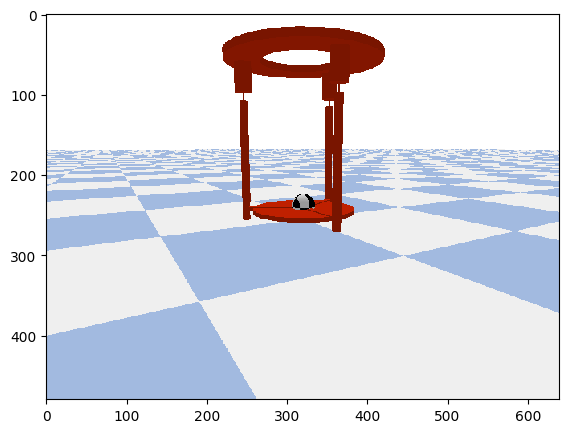

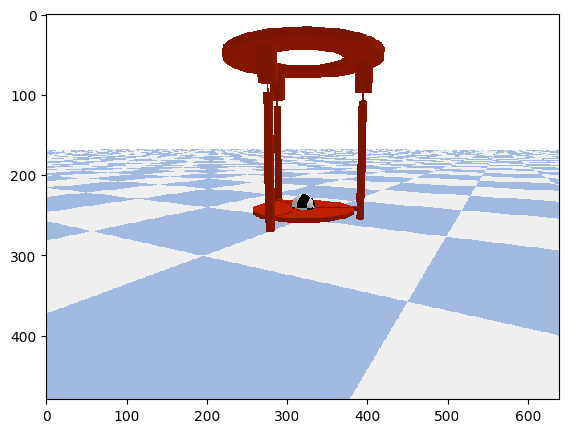

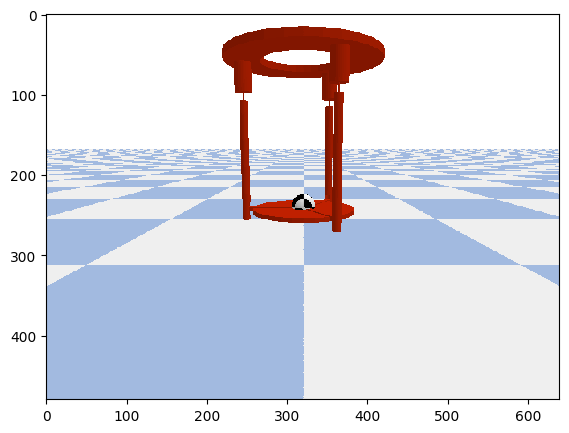

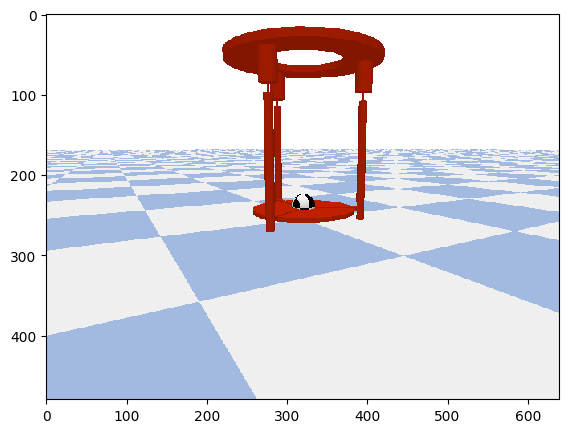

In [12]:
from google.colab import widgets
import numpy as np
import random
import time
from matplotlib import pylab
grid = widgets.Grid(2, 2)
yaw = 0
for r in range(2):
  for c in range(2):
    yaw += 60
    with grid.output_to(r, c):
      grid.clear_cell()
      pylab.figure(figsize=(10, 5))
      pitch = -10.0
      roll = 0
      upAxisIndex = 2
      camDistance = 2.5
      pixelWidth = 640
      pixelHeight = 480
      nearPlane = 0.01
      farPlane = 100
      fov = 60
      viewMatrix = p.computeViewMatrixFromYawPitchRoll(camTargetPos, camDistance, yaw, pitch,
                                                                  roll, upAxisIndex)
      aspect = pixelWidth / pixelHeight
      projectionMatrix = p.computeProjectionMatrixFOV(fov, aspect, nearPlane, farPlane)

      img_arr = p.getCameraImage(pixelWidth,pixelHeight,viewMatrix,projectionMatrix)
      w = img_arr[0]  #width of the image, in pixels
      h = img_arr[1]  #height of the image, in pixels
      rgb = img_arr[2]  #color data RGB
      dep = img_arr[3]  #depth data
      print("w=",w,"h=",h)
      np_img_arr = np.reshape(rgb, (h, w, 4))
      np_img_arr = np_img_arr * (1. / 255.)
      pylab.imshow(np_img_arr, interpolation='none', animated=True, label="pybullet")


## Try moving PIPPA 🎮 🐧

Posizione iniziale del giunto 14: (-0.20446797780374448, 0.37552717983999434, 0.20373667336787218)
Orientamento iniziale del giunto 14: (0.003387472704293847, -0.0033880245502702906, 1.316298813808237e-06, 0.9999885230924362)
Posizione iniziale Base: (0.009398301778662648, 0.00939871296302286, 0.002699856043682921)
Orientamento iniziale Base: (0.0033896819186064573, -0.0033890663446009546, -6.575123029353471e-09, 0.9999885120769151)
Posizione finale del giunto 14: (-0.18621180859312855, 0.393783707872521, 0.20860553624394645)
Orientamento finale del giunto 14: (0.011096515965357488, -0.011095681895923136, 1.270366607047939e-06, 0.9998768690069199)
Posizione finale Base: (0.03078256499845824, 0.03078391525011172, 0.005268020273917756)
Orientamento finale Base: (0.011102704871975691, -0.011100682326858388, -4.347825361721033e-08, 0.9998767448022792)


,
,


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

w= 640 h= 480


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

w= 640 h= 480


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

w= 640 h= 480


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

w= 640 h= 480


<IPython.core.display.Javascript object>

CPU times: user 699 ms, sys: 35.9 ms, total: 735 ms
Wall time: 5.03 s


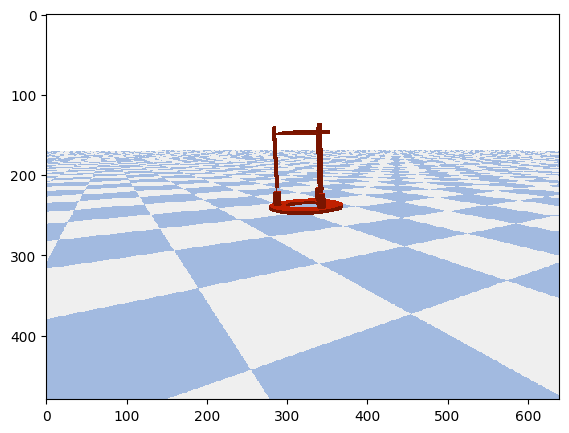

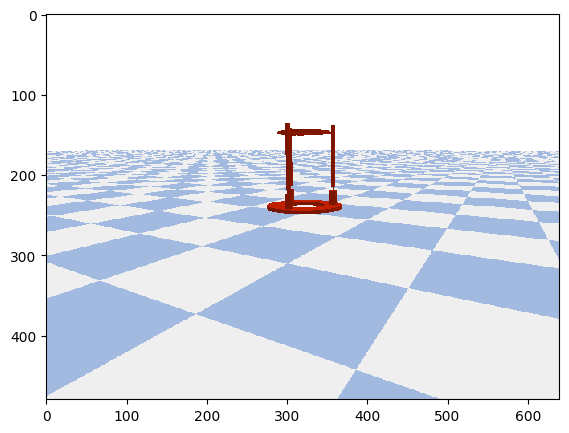

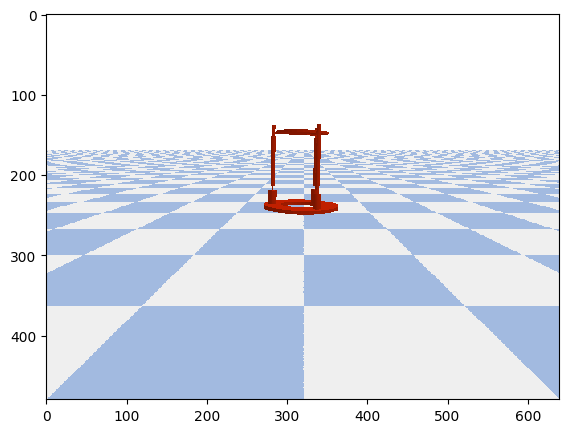

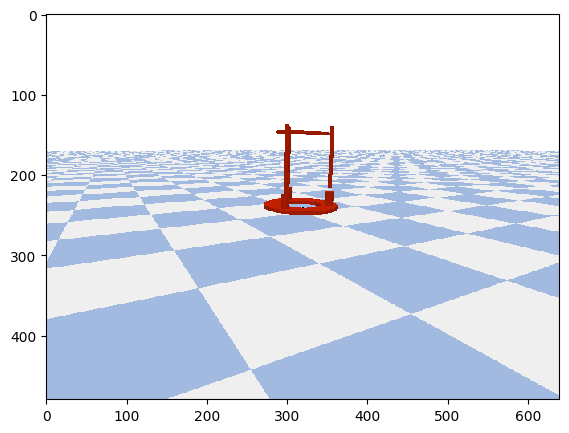

In [ ]:
%%time
force = np.array([100,100,0])
force_position = np.array([0,0,0])

initial_position_base, initial_orientation_base = p.getBasePositionAndOrientation(PIPPA_id)
initial_position_leg, initial_orientation_leg = p.getLinkState(PIPPA_id, 14)[:2]

print("Posizione iniziale del giunto 14:", initial_position_leg)
print("Orientamento iniziale del giunto 14:", initial_orientation_leg)
print("Posizione iniziale Base:", initial_position_base)
print("Orientamento iniziale Base:", initial_orientation_base)

p.applyExternalForce(
    objectUniqueId=PIPPA_id,linkIndex= -1,forceObj=force,posObj=force_position,flags=p.LINK_FRAME)

for _ in range(1000):
    p.stepSimulation()  # Aggiorna la simulazione
    time.sleep(1./240.)  # Ritardo per simulare 240 Hz

final_position_base, final_orientation_base = p.getBasePositionAndOrientation(PIPPA_id)
final_position_leg, final_orientation_leg = p.getLinkState(PIPPA_id, 14)[:2]

print("Posizione finale del giunto 14:", final_position_leg)
print("Orientamento finale del giunto 14:", final_orientation_leg)

print("Posizione finale Base:", final_position_base)
print("Orientamento finale Base:", final_orientation_base)

grid = widgets.Grid(2, 2)
yaw = 0
for r in range(2):
  for c in range(2):
    yaw += 60
    with grid.output_to(r, c):
      grid.clear_cell()
      pylab.figure(figsize=(10, 5))
      pitch = -10.0
      roll = 0
      upAxisIndex = 2
      camDistance = 5
      pixelWidth = 640
      pixelHeight = 480
      nearPlane = 0.01
      farPlane = 100
      fov = 60
      viewMatrix = p.computeViewMatrixFromYawPitchRoll(camTargetPos, camDistance, yaw, pitch,
                                                                  roll, upAxisIndex)
      aspect = pixelWidth / pixelHeight
      projectionMatrix = p.computeProjectionMatrixFOV(fov, aspect, nearPlane, farPlane)

      img_arr = p.getCameraImage(pixelWidth,pixelHeight,viewMatrix,projectionMatrix)
      w = img_arr[0]  #width of the image, in pixels
      h = img_arr[1]  #height of the image, in pixels
      rgb = img_arr[2]  #color data RGB
      dep = img_arr[3]  #depth data
      print("w=",w,"h=",h)
      np_img_arr = np.reshape(rgb, (h, w, 4))
      np_img_arr = np_img_arr * (1. / 255.)
      pylab.imshow(np_img_arr, interpolation='none', animated=True, label="pybullet")

